In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

In [ ]:
!sudo rm -R /root/.kaggle
!mkdir kaggle
!mv kaggle .kaggle

!sudo cp /content/drive/MyDrive/folder/kaggle.json /content/.kaggle
!sudo mv /content/.kaggle /root/

!pip install kaggle
!kaggle competitions download cisc873-dm-w24-a6
!unzip /content/cisc873-dm-w24-a6.zip

cisc873-dm-w24-a6.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/cisc873-dm-w24-a6.zip
replace gcnn-template.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Read SDF format data (structured-data format)

Each line can be either a link, a node or a class depending on its value, if it starts with

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')

    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
          # checking if the line is from class 1 or class 0
          # or whether it is a node or a link based on its value
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1,
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]




In [ ]:
from sklearn.model_selection import train_test_split

training_set = read_sdf("/content/train.sdf")
training_set, validation_set = train_test_split(training_set, test_size=0.15, shuffle = True)
testing_set  = read_sdf("/content/test_x.sdf")

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
print(training_set[1])

(['Ir', 'O', 'O', 'O', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  1],
       [ 0,  4],
       [ 0, 12],
       [ 0, 13],
       [ 1,  7],
       [ 2, 12],
       [ 3, 13],
       [ 4,  5],
       [ 4,  9],
       [ 5,  6],
       [ 6,  7],
       [ 6,  8],
       [ 7, 11],
       [ 8, 10],
       [ 8, 15],
       [ 9, 16],
       [ 9, 17],
       [10, 14],
       [10, 18],
       [11, 14],
       [15, 19],
       [16, 21],
       [17, 22],
       [18, 20],
       [19, 20],
       [21, 23],
       [22, 23]]), 0)


## Visualizing/Inspecting a Sample

In [ ]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [145]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]

    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
      # adding nodes and colors for the node in the graph
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()

    return G

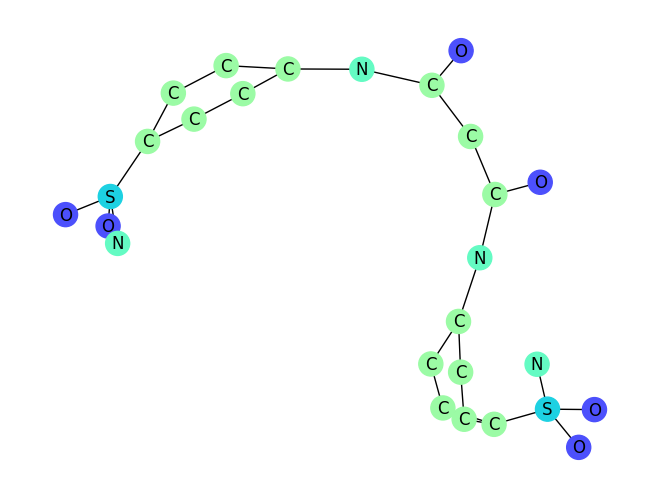

In [146]:
plt.clf()
visualize(training_set[20])

## Preprocessing:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
  # prepare the data for a single batch for training or testing

  # selecting nodes and edges that are going to be used int he batch
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

In [ ]:
# from .rgat import RGAT
# from .rgcn import RGCN
# from .rgin import RGIN
# from .ggnn import GGNN
# from .gnn_edge_mlp import GNN_Edge_MLP
# from .gnn_film import GNN_FiLM
from keras.layers import Layer, Input

In [ ]:
class ReduceMaxLayer(Layer):
    def call(self, inputs):
        # Apply the TensorFlow reduce_mean function
        return tf.reduce_max(inputs) + 1

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
import math

In [ ]:
def define_model(params):

  data = keras.Input(batch_shape=(None,))

  # the first dim is different to the previous one. it is the total number of edges in this batch
  edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
  node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
  embeded = Embedding(tokenizer.num_words, 20)(data)

  # number of graphs (number of samples)
  num_graph = tf.reduce_max(node2graph)+1

  gnn_input = GNNInput(
      node_features=embeded,
      adjacency_lists=(edge,),
      node_to_graph_map=node2graph,
      num_graphs=num_graph,
  )

  gnn_layer = GNN(params)
  gnn_out = gnn_layer(gnn_input)

  avg = segment_mean(
      data=gnn_out,
      segment_ids=node2graph
  )

  pred = Dense(1, activation='sigmoid')(avg)

  model = Model(
      inputs={
          'data': data,
          'edges': edge,
          'node2grah': node2graph,
      },
      outputs=pred
  )
  model.summary()

  return model

In [187]:
for i in gen_batch(
          training_set, batch_size=1, repeat=True
      ):
  print(i[0]["data"].shape)
  print(i[0]["edges"].shape)
  print(i[0]["node2grah"].shape)
  break

(19,)
(21, 2)
(19,)


In [91]:
def fit_model(batch_size, model, epochs, patience = 5):

  model.compile(
      loss='BinaryCrossentropy',
      metrics=['AUC']
  )

  num_batchs = math.ceil(len(training_set) / batch_size)
  num_batchs_validation = math.ceil(len(validation_set) / batch_size)

  model.fit(
      gen_batch(
          training_set, batch_size=batch_size, repeat=True
      ),
      steps_per_epoch=num_batchs,
      epochs=epochs,
      validation_data=gen_batch(
          validation_set, batch_size=batch_size, repeat=True
      ),
      callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
        ],
      validation_steps=num_batchs_validation,
  )

To start experimenting we first need to have a look on the repo documentation and the hyperparameters including the message passing algorithms used, below is a table of the performance of different models from the documentation as well

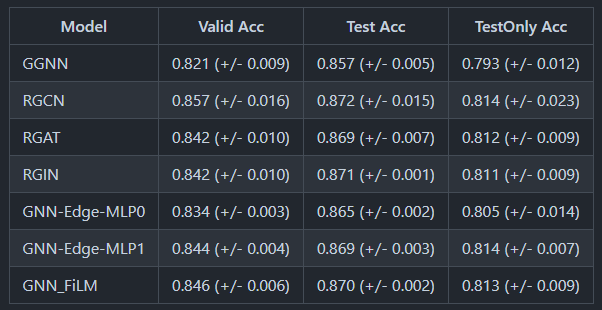

GGNN: Gated Graph Sequence Neural Networks: designed for graph-structured data. They use GRU cells to iteratively update node representations based on the graph structure, mapping these representations to outputs for tasks like classification or sequence prediction. (the paper was publishd in 2016)

R-GCN: Relational Graph Convolutional Networks handles graph-structured data where the goal is to produce sequences as outputs. These networks learn features from graph inputs and utilize gated recurrent units for effective handling of sequential outputs. (2017) achieved better results according to the library documentation.

RGAT: Graph Attentoin Networks GATs have demonstrated state-of-the-art results across various benchmarks, offering computational efficiency, model capacity, and applicability to inductive learning problems. (2018) according to the documentation it performed better than the previous ones

GNN_FiLM: uses feature-wise linear modulation (FiLM) to modulate the information passed along the edges of a graph. (2020) also considered better than the previous ones

Now it is time to try those with different configurations.

# Experiment 1

There are many types of Graph Neural Networks as stated in the library that is used in the template, I will be following the benchmarking results above from the library page and I will use it in sequence from lowest to highest depending on the results of each experiment.

For the first model I am going to use a Graph NN with hidden dimensions = 32 which is the template tht is provided, this one will be used as baseline to check what can be improved.

In [144]:
GNN.get_default_hyperparameters()

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'GGNN'

# make a model with the
model = define_model(params)
fit_model(64, model, 200)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_5 (TFOp  ()                           0         ['input_18[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_5 (Embedding)     (None, 20)                   10000     ['input_16[0][0]']      

The model is clearly underfitting, which means that we can have a model with more capacity to get better results.

# Experiment 2

In this experiment I will add more layers to the model to check if this wuld make it better.

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["num_layers"] = 10
params['message_calculation_class'] = 'GGNN'

# make a model with the
model = define_model(params)
fit_model(64, model, 200)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_6 (TFOp  ()                           0         ['input_21[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_6 (Embedding)     (None, 20)                   10000     ['input_19[0][0]']      

Still not yeilding good results, so we can go to a better model as shown in the benchmarking table that was found in the lbrary repo, next time we will try RGCN with the basic configurations.

# Expriment 3

we will try the RCGN with the default parameters to check if we can reduce bias.

In [ ]:
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'RGCN'

# make a model with the
model = define_model(params)
fit_model(64, model, 200)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_37 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_12 (TFO  ()                           0         ['input_39[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_12 (Embedding)    (None, 20)                   10000     ['input_37[0][0]']      

Results seems to be slightly better in average, some of the epochs has AUC greater than 0.7 which is an improvement. In the next experiment I will add more layers and try again with the same message passing algorithm.

# Experiment 4
 Using 64 hidden dimensions and 10 hidden layers

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 50
params["num_layers"] = 1

params['message_calculation_class'] = 'RGCN'

# make a model with the
model = define_model(params)
fit_model(16, model, 200)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_6 (TFOp  ()                           0         ['input_21[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_6 (Embedding)     (None, 20)                   10000     ['input_19[0][0]']      

Results are not improving much, so I will be using the next model in the table.


# Experiment 5
Now I will try the RGAT message-passing model which might peprform better.

In [ ]:
params["hidden_dim"] = 64
params['message_calculation_class']= 'RGAT'
params['num_heads']= 4

model = define_model(params)
fit_model(16, model, 200)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_3 (TFOp  ()                           0         ['input_12[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_3 (Embedding)     (None, 20)                   10000     ['input_10[0][0]']        

It still didn't improve much, but I will try a deeper model and different configrations to try making the model better and having more capacity.

# Experiment 6
Using RGAT with more num_heads, hidden dimensions = 100, num_layers = 10

In [ ]:
params["hidden_dim"] = 64
params['message_calculation_class']= 'RGAT'
params["num_layers"] = 5
params['num_heads']= 8

model = define_model(params)
fit_model(16, model, 200)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_31 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_10 (TFO  ()                           0         ['input_33[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_10 (Embedding)    (None, 20)                   10000     ['input_31[0][0]']      

Not much improved still so I will try the next model which should be better or simillar to this.

# Experiment 7

In this experiment I will try the last message calculation class GNN_FiLM with one film_parameter_MLP_hidden_layers

In [84]:
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'GNN_FiLM'
params["film_parameter_MLP_hidden_layers"] = 1
# make a model with the
model = define_model(params)
fit_model(64, model, 200, 2)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_69 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_67 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_22 (TFO  ()                           0         ['input_69[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_22 (Embedding)    (None, 20)                   10000     ['input_67[0][0]']      

Results from this experiment are much more promising than the previous ones, but maybe increasing the number of mlp hidden layer would be giving the model more cpacity and make it better.

# Experiment 8
Smae model as before but increasing the number of mlp layers in the parameters.

In [87]:
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'GNN_FiLM'
params["film_parameter_MLP_hidden_layers"] = 5
# make a model with the
model = define_model(params)
fit_model(64, model, 200, 2)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_72 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_70 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_23 (TFO  ()                           0         ['input_72[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_23 (Embedding)    (None, 20)                   10000     ['input_70[0][0]']      

Didn't improve from the previous one, but in general the GNN_FiLM is the best till now, next I will try balancing the data to check if this would make the AUC score higher using the same algorithm.

# Experiment 9

In this experiment I will try the RGAT message passing with upsampling to be able to compare it with GNN_FiLM and check the results, I am expecting the results to be much better than before.

In [89]:
training_set = read_sdf("/content/train.sdf")
# training_set, validation_set = train_test_split(training_set, test_size=0.15, shuffle = True)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [118]:
pd.DataFrame(training_set)[2].value_counts()

2
0    23806
1     1218
Name: count, dtype: int64

In [132]:
upsampled = pd.DataFrame(training_set).groupby(2).apply(lambda x: x.sample(23806, replace = True) if (x[2] == 1).any() else x)

In [136]:
training_set = upsampled.values
training_set, validation_set = train_test_split(training_set, test_size=0.15, shuffle = True)

In [137]:
params["hidden_dim"] = 64
params['message_calculation_class']= 'RGAT'
params["num_layers"] = 5
params['num_heads']= 8

model = define_model(params)
fit_model(16, model, 200, 2)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_75 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_73 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_24 (TFO  ()                           0         ['input_75[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_24 (Embedding)    (None, 20)                   10000     ['input_73[0][0]']      

As expected there is much improvement in the results and on the leaderboard as well, but now I will try the FiLM model.

# Experiment 10

In [141]:
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'GNN_FiLM'
params["film_parameter_MLP_hidden_layers"] = 1
# make a model with the
model = define_model(params)
fit_model(64, model, 200, 2)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_78 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_76 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_25 (TFO  ()                           0         ['input_78[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 embedding_25 (Embedding)    (None, 20)                   10000     ['input_76[0][0]']      

The results are simillar to the previous one but slightly improved on the public leaderboard to 0.85418 while it was 0.84305

# Conclusion and future work

It is very notable to see that the result improved significantly after doing the upsampling, while it might have been better if I tried optimizing the hyperparameters using bayesian optimization but the runtime of the algorithm is too much for the limited resources that I have.

Other algorithms for the upsampling can also be researched.

In [142]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 7s 8ms/step


In [143]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submissionTrialdata.csv')